# CS-675 Project Team 1

The objective of this project is to create a model for successful telephone based marketing campaigns in the fincial services industry based on data collected over a 4 year period by a Portuguese bank. The data was collected on in-bound and out-bound phone calls made to clients in an attempt to get them to register for a term account with the bank. Initially 150 variables were monitored, and subsequent analysis was performed to reduce that to a set of 21 features for use in model creation. The specific features included both client specific ones (e.g., age, occupation, marital status, etc.) as well as economic indicators such as the employment variation and interest rates, consumer price and confidence index, etc. A complete list is available in the included file "bank-additional-names.txt".

The goal was to predict if a client will subscribe to a term deposit or not. So when this model is deployed on the unseen data, it predicts with atmost 90% accuracy.
This information can be very helpful for the marketing team, as they can now focus more on the clients that are the most likely to subscribe and those who aren't.

The approach taken in this notebook is evaluate the data using two classifiers; a Random Forest and a Neural Network. Later more algorithms were added to see if we can increase the accurary. The choices were made based on two criteria:

1. see which classifier has a higher model score.
2. given our objective of marketing campaign creation, to contrast the usefulness of a classifier with "interprettable results" such the Random Forest with a "black box" one such as a Neural Network in which the features are not directly returned.

The actual cell execution proceeds as follows:

1. the data is read into a pandas data frame
2. preprocess (using binning) on a feature (pdays) that represents the number of days that elapsed between contacting the client for the current campaign and any previuos campaigns. This was done because the value of 999 was used to indicate 'unknown', and the values for known day counts ranged between 0 and 40.
3. categorical variables are one-hot encoded
4. one feature from the dataset (the call duration) was dropped because it would not be possible to know prior how long a call might last and therefore would not be useful in an actual campaign.
Also if the value is 0, the output will always be no. So it acts like a bias hence not included.

The data was split into 80%-20% training/test data sets and the appropriate class was fit on the training data and run on the test data. In the case of the Random Forest, the results output include the classifier score, the ranking of the features and a plot of the top 20. In the case of the Neural Network, the score and the classifier coefficients are printed.

In [0]:
#!pip install xgboost
#!pip install scikit-plot

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
plt.rcParams["figure.figsize"] = (10,10)

np.random.seed(0)

df_bank = pd.read_csv('/content/drive/My Drive/Group 1/bank-additional-full.csv', sep=';')
#df_bank = pd.read_csv('bank-additional-full.csv', sep=';')

df_bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [0]:
df_bank.shape

(41188, 21)

In [0]:
# Bin values of feature 'pday' given the wide spread in the value (999) for unknown contact days
df_bank['pdays_binned'] = pd.cut(x=df_bank['pdays'], bins=[-1,5.1,10.1,20.1,30.1,1000], labels=['Less than 5','5-10', '10-20', '20-30', 'unknown'])

# Drop unneeded columns
X = df_bank.drop(columns=['duration','pdays','y'])

# Use one-hot encoding for categoricals
X = pd.get_dummies(X)
y = df_bank['y']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)



In [0]:
# standardizing the data
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

### Random Forest Classifier

model score: 0.894

01) age                            0.149693
02) euribor3m                      0.118319
03) campaign                       0.079613
04) nr.employed                    0.047774
05) emp.var.rate                   0.033101
06) cons.conf.idx                  0.025081
07) cons.price.idx                 0.022834
08) housing_yes                    0.020620
09) housing_no                     0.020521
10) pdays_binned_unknown           0.019383
11) job_admin.                     0.018368
12) marital_married                0.018177
13) education_university.degree    0.017430
14) education_high.school          0.017411
15) marital_single                 0.016490
16) day_of_week_wed                0.015522
17) day_of_week_thu                0.015451
18) day_of_week_mon                0.015340
19) poutcome_success               0.015214
20) day_of_week_tue                0.015122
21) day_of_week_fri                0.014795
22) job_technician                 0.014488
23) loan_no 

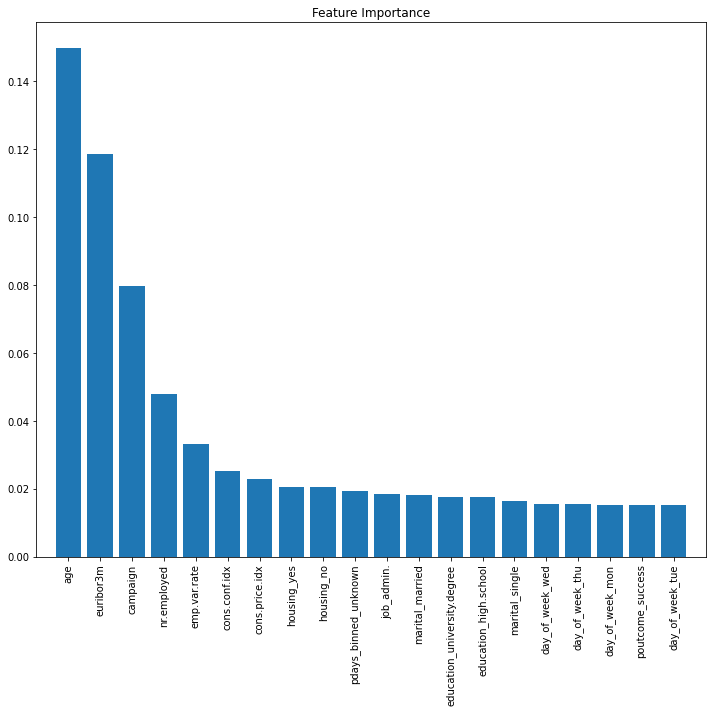

In [0]:
#### Run Random Forest classifier

# Instantiate classifier and run fit on training set
clf = RandomForestClassifier(n_estimators = 500, criterion='entropy', random_state=1)
clf.fit(X_train_std, y_train)

# Display results
print("model score: %.3f\n" % clf.score(X_test_std, y_test))

feat_labels = X_test.columns[:]
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%02d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))


plt.title('Feature Importance')
plt.bar(range(20), importances[indices[:20]],
        align='center')

plt.xticks(range(20), feat_labels[indices[:20]], rotation=90)
plt.xlim([-1, 20])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()


### Neural Network Classifier

In [0]:
### Run Neural Network classifier

from sklearn.neural_network import MLPClassifier

# Instantiate classifier and run fit on training set
nn = MLPClassifier(hidden_layer_sizes=(2,6,2), random_state=1)

nn.fit(X_train_std, y_train)

# Display results
print("model score: %.3f\n" % nn.score(X_test_std, y_test))
print(nn.coefs_[0][0])
#print(clf.coefs_[1][0])


model score: 0.899

[-0.27963399 -0.04817562]


### Logistic Regression Classifier

In [0]:
# Training a LogisticRegression Model

LR = LogisticRegression()
LR.fit(X_train_std, y_train)

LR_Predict = LR.predict(X_test_std)

LR_acc = round(accuracy_score(y_test, LR_Predict),2)

LR_final = LR_acc*100
print(LR_final)

90.0


### XGBoost Classifier

In [0]:
# Training a XGboost classifier
# More on this can be found here : https://towardsdatascience.com/a-beginners-guide-to-xgboost-87f5d4c30ed7
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate= 0.03, booster ='gbtree')
xgb.fit(X_train_std, y_train)

xgbPre = xgb.predict(X_test_std)

xgb_acc = round(accuracy_score(y_test, xgbPre),2)


print("Accuracy :", xgb_acc*100)


NameError: ignored

### SVM Classifier

In [0]:
#expect higher runtime (approx 10 minutes)
svm_clf = SVC(probability=True, gamma='auto')
svm_clf.fit(X_train, y_train)

print ("Accuracy : ", round(svm_clf.score(X_test, y_test)*100,2))

NameError: name 'SVC' is not defined